In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm,skew
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone # tüm modellerimi birlestirirken kullanicam

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [16]:
column_name = ["MPG","Cylinders","Displacement","Horsepower","weight","Acceleration","Model Year","Origin"]

In [18]:
df = pd.read_csv("auto-mpg.data",names = column_name, na_values = "?", comment ="\t", sep=" ", skipinitialspace= True)
df.head()

,MPG,Cylinders,Displacement,Horsepower,weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [19]:
df.tail()

,MPG,Cylinders,Displacement,Horsepower,weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [21]:
df.describe()

,MPG,Cylinders,Displacement,Horsepower,weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


**Mean değeri medyan değerinden büyük ise normal dağılım olmaz. mean değeri medyan değerinden büyük olursa sola doğru yatık yani sağa tarafa doğru kuyrugu olan pozitiz skew'e sahip olur.**


In [22]:
df = df.rename(columns = {"MPG":"target"})
df.head()

,target,Cylinders,Displacement,Horsepower,weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [23]:
df.shape

(398, 8)

In [24]:
df.isna().sum()

target          0
Cylinders       0
Displacement    0
Horsepower      6
weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

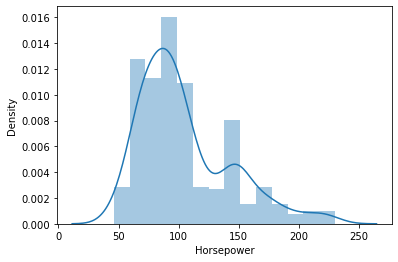

In [26]:
df["Horsepower"] = df["Horsepower"].fillna(df["Horsepower"].mean())
sns.distplot(df["Horsepower"]);

# EDA

In [28]:
corr_matrix = df.corr()

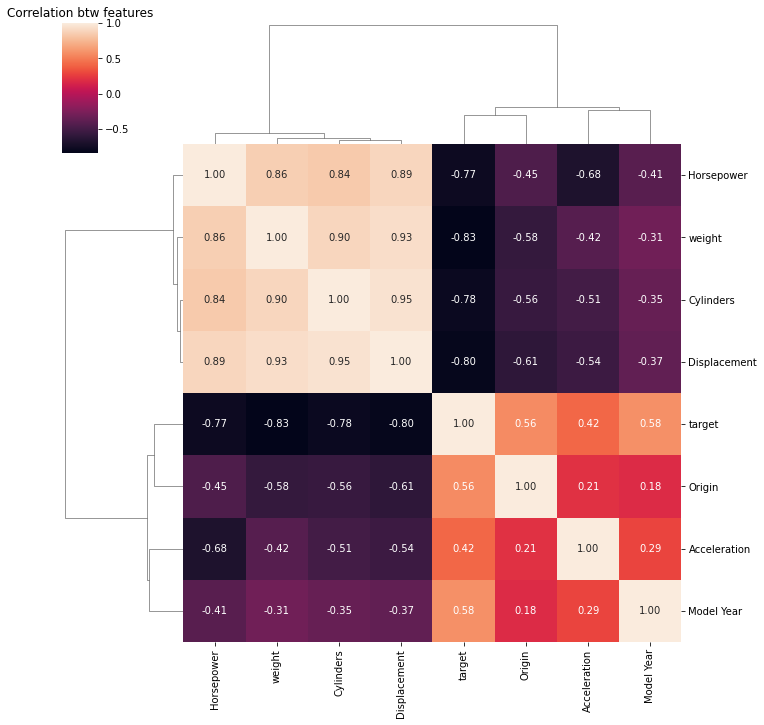

In [29]:
sns.clustermap(corr_matrix,annot = True, fmt =".2f")
plt.title("Correlation btw features")
plt.show()

* threshold 0.75 üzeri olan featurlerı görebilmek için. pairplotta kolay göreyim ve korelasyon matrisimi küçültmek için yapıyorum.

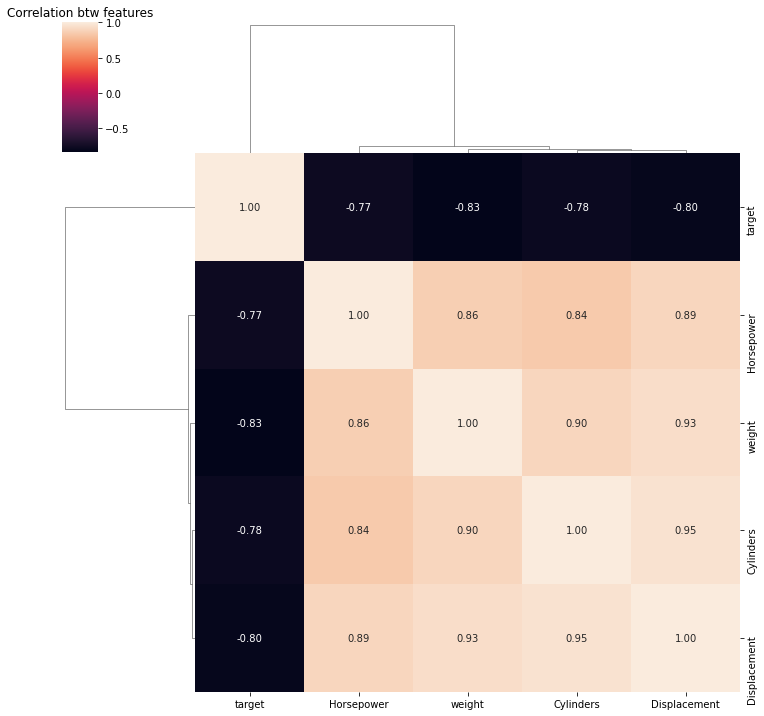

In [31]:
threshold = 0.75
filtre = np.abs(corr_matrix["target"])> threshold
corr_feature = corr_matrix.columns[filtre].tolist()

sns.clustermap(df[corr_feature].corr(),annot = True, fmt =".2f")
plt.title("Correlation btw features")
plt.show()